In [53]:
import numpy as np
import networkx as nx
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from sklearn.cluster import SpectralClustering
from sklearn.metrics.pairwise import cosine_similarity
import statistics as st

In [54]:
# Example data
n = 5  # Number of nodes
d = 10  # Dimension of model parameters
X = [np.random.rand(10, d) for _ in range(n)]  # Local datasets
y = [np.random.rand(10) for _ in range(n)]  # Outputs
alpha = 1.0

In [55]:
# Compute the similarity matrix based on the datasets
similarity_matrix = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        if i != j:
            #similarity_matrix[i, j] = cosine_similarity(X[i], X[j]).mean()
            similarity_matrix[i, j] = 1 / (np.linalg.norm(X[i] - X[j]))
print(similarity_matrix)

[[0.         0.24919937 0.23539172 0.24832525 0.23510431]
 [0.24919937 0.         0.23800007 0.22909724 0.24723442]
 [0.23539172 0.23800007 0.         0.22627303 0.24809062]
 [0.24832525 0.22909724 0.22627303 0.         0.21738454]
 [0.23510431 0.24723442 0.24809062 0.21738454 0.        ]]


In [56]:
# Perform spectral clustering
n_clusters = 2  # Number of clusters
spectral = SpectralClustering(n_clusters=n_clusters, affinity='precomputed')
labels = spectral.fit_predict(similarity_matrix)
print(labels)

[1 0 0 1 0]


In [57]:
# Create a similarity graph representing the cluster structure
G = nx.Graph()
for i in range(n):
    for j in range(i + 1, n):
        if similarity_matrix[i, j] > 0: # Only add edges with positive weights
            G.add_edge(i, j, weight=similarity_matrix[i, j])
print(G)

Graph with 5 nodes and 10 edges


In [58]:
# Define the local loss function for each node
def local_loss(w, X, y):
    return np.sum((y - X @ w) ** 2)

In [59]:
# Define the objective function that includes local loss and total variation
def objective(w, X, y, A, alpha, n, d):
    w = w.reshape((n, d))
    loss = sum(local_loss(w[i], X[i], y[i]) for i in range(n))
    tv = 0
    for i in range(n):
        for j in range(n):
            if i != j and A[i, j] > 0:
                tv += A[i, j] * np.linalg.norm(w[i] - w[j]) ** 2
    return loss + alpha * tv

In [60]:
def custom_minimize(objective, w_init, args, learning_rate=0.01, max_iter=10):
    w = w_init.copy()
    n, d = args[3], args[4]

    # Aggregate all data points from the nodes in the cluster
    X_all = np.vstack(args[0])  # Combine all X datasets in the cluster
    y_all = np.hstack(args[1])  # Combine all y datasets in the cluster

    for iteration in range(max_iter):
        grad = np.zeros_like(w)
        w_reshaped = w.reshape((n, d))

        # Calculate the loss using the aggregated data for all nodes
        loss = sum(local_loss(w_reshaped[i], X_all, y_all) for i in range(n))

        # Calculate the gradient of the total variation term
        for i in range(n):
            for j in range(n):
                if i != j and args[2][i, j] > 0:
                    grad[i * d: (i + 1) * d] += 2 * args[5] * args[2][i, j] * (w_reshaped[i] - w_reshaped[j])
                    grad[j * d: (j + 1) * d] -= 2 * args[5] * args[2][i, j] * (w_reshaped[i] - w_reshaped[j])

        # Calculate the gradient of the loss function using the aggregated data
        grad_loss = np.zeros_like(w)
        for i in range(n):
            grad_loss[i * d: (i + 1) * d] = 2 * (X_all.T @ (X_all @ w_reshaped[i] - y_all))

        grad += grad_loss

        # Update the weights using the gradient
        w -= learning_rate * grad

        # Check convergence based on the gradient's norm
        if np.linalg.norm(grad) < 1e-6:
            break

    return w


In [61]:
# Function to verify the error bound for each cluster
def verify_theorem_1_bound(G, cluster_nodes, w_hat, w_C, epsilon_C, alpha, R):
    boundary_edges = [e for e in G.edges if (e[0] in cluster_nodes) != (e[1] in cluster_nodes)]
    boundary_size = len(boundary_edges)

    sum_squared_norms = sum(np.linalg.norm(w_hat[i] - w_C)**2 for i in range(len(cluster_nodes)))

    subgraph = G.subgraph(cluster_nodes)
    L_C_matrix = nx.laplacian_matrix(subgraph).toarray()
    L_C = np.sort(np.linalg.eigvals(L_C_matrix))[1]

    upper_bound = (1 / (alpha * L_C)) * (epsilon_C + alpha * boundary_size * 2 * (np.linalg.norm(w_C)**2 + R**2))

    return sum_squared_norms, upper_bound

In [62]:
# Optimize model parameters for each cluster
cluster_parameters = {}
for cluster in range(n_clusters):
    cluster_nodes = [i for i, label in enumerate(labels) if label == cluster]
    X_cluster = [X[i] for i in cluster_nodes]
    y_cluster = [y[i] for i in cluster_nodes]
    w_init_cluster = np.random.rand(len(cluster_nodes) * d)

    similarity_matrix_cluster = similarity_matrix[np.ix_(cluster_nodes, cluster_nodes)]
    args_cluster = (X_cluster, y_cluster, similarity_matrix_cluster, len(cluster_nodes), d, alpha)

    w_opt_cluster = custom_minimize(objective, w_init_cluster, args_cluster).reshape((len(cluster_nodes), d))
    cluster_parameters[cluster] = (cluster_nodes, w_opt_cluster)

In [63]:
# Print optimized parameters for each cluster
for cluster, (cluster_nodes, w_opt) in cluster_parameters.items():
    print(f"Optimized model parameters for cluster {cluster}:\n", w_opt)

Optimized model parameters for cluster 0:
 [[ 0.18453455 -0.05359099  0.24964177  0.31263116 -0.10499886  0.17802411
  -0.21324716  0.24829585  0.09410236  0.10849657]
 [-0.09337751  0.20411126  0.21260085  0.07815752  0.34665771 -0.0476342
  -0.16450751  0.53038917  0.02002249 -0.01952143]
 [ 0.19224426 -0.02548409 -0.1140219   0.39268578 -0.00100435 -0.06619169
  -0.23582426  0.33927639  0.37618849  0.19952412]]
Optimized model parameters for cluster 1:
 [[ 0.10753747  0.17872085  0.35917098  0.22888869  0.13015909  0.11808373
  -0.15210414 -0.15408006  0.12218548  0.44910362]
 [ 0.37413976 -0.12539934  0.59130639 -0.08634181  0.01673041  0.44623481
  -0.0982906   0.12437233  0.05763166 -0.02344402]]


In [64]:
# Verify the error bound for each cluster and plot the results
cluster_sums = []
cluster_bounds = []
for cluster, (cluster_nodes, w_opt) in cluster_parameters.items():
    w_C = np.mean(w_opt, axis=0)  # Cluster-specific parameters as the mean of optimized parameters
    epsilon_C = 0.001
    R = 0.001

    # Verify the bound and get the sum of squared norms and upper bound
    sum_squared_norms, upper_bound = verify_theorem_1_bound(G, cluster_nodes, w_opt, w_C, epsilon_C, alpha, R)

    cluster_sums.append(sum_squared_norms)
    cluster_bounds.append(upper_bound)
    print(f'sum of squared deviation is {sum_squared_norms} of cluster {cluster + 1}')
    print(f'upper bound on deviation for cluster {cluster +1} is {upper_bound}')

sum of squared deviation is 0.5143046012222968 of cluster 1
upper bound on deviation for cluster 1 is 5.239831315299891
sum of squared deviation is 0.3726361408765903 of cluster 2
upper bound on deviation for cluster 2 is 10.728183895511537


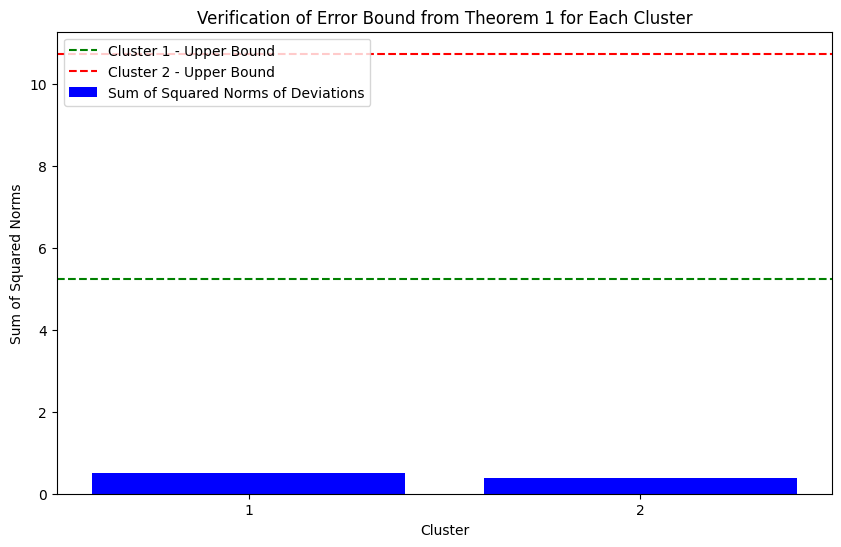

In [65]:
# Plot the results cluster-wise
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
plt.figure(figsize=(10, 6))
clusters = list(cluster_parameters.keys())

clusters = [x + 1 for x in clusters]

plt.bar(clusters, cluster_sums, color='b', label='Sum of Squared Norms of Deviations')

count = 0
for i in cluster_bounds:
    count += 1
    plt.axhline(y=i, color=colors[count % len(colors)], linestyle='--', label=f'Cluster {count} - Upper Bound')

plt.xlabel('Cluster')
plt.ylabel('Sum of Squared Norms')
plt.xticks(clusters, [str(cluster) for cluster in clusters])
plt.title('Verification of Error Bound from Theorem 1 for Each Cluster')
plt.legend(loc='upper left')
plt.show()